### **1. Import libraries**

In [1]:
import os 
import random 
import time 
import xml.etree.ElementTree as ET 

import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import timm 
import torch 
import torch.nn as nn 
import torchvision 
from PIL import Image 
from sklearn.model_selection import train_test_split 
from torch.nn import functional as F 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms 

### **2. Extract Data from XML and Store in New Folder**

#### **Extract**

In [2]:
def extract_data_from_xml(root_dir):
    xml_path = os.path.join(root_dir, "words.xml")
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    for img in root:
        bbs_of_img = []
        labels_of_img = []

        for bbs in img.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_img.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_img.append(bb[0].text.lower())

        relative_path = img[0].text.replace('/', os.sep)
        img_path = os.path.join(root_dir, relative_path)
        img_paths.append(img_path)
        img_sizes.append((int(img[1].attrib["x"]), int(img[1].attrib["y"])))
        bboxes.append(bbs_of_img)
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes


In [3]:
dataset_dir = "datasets/SceneTrialTrain"
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)

In [4]:
print(f"Total images: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total images: 250
Total bounding boxes: 1097


### **Plot an example**

In [5]:
def plot_image_with_bbs(img_path, bbs, labels):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for idx, bb in enumerate(bbs):
        start_point = (int(bb[0]), int(bb[1]))
        end_point = (int(bb[0] + bb[2]), int(bb[1] + bb[3]))
        color = (255, 0, 0)
        thickness = 2 
        img = cv2.rectangle(img, start_point, end_point, color, thickness)
        
        font = cv2.FONT_HERSHEY_SIMPLEX 
        font_scale = 0.5 
        font_color = (255, 255, 255)
        line_type = 2 
        text_thickness = 2 
        label = labels[idx]
        text_size, _ = cv2.getTextSize(label, font, font_scale, text_thickness)

        label_background_start = (int(bb[0]), int(bb[1] - text_size[1] - 10))
        label_background_end = (int(bb[0] + text_size[0]), int(bb[1]))
        ing = cv2.rectangle(
            img, label_background_start, label_background_end, color, cv2.FILLED
        )
        
        cv2.putText(
            img, 
            label, 
            (int(bb[0]), int(bb[1] - 10)), 
            font, 
            font_scale, 
            font_color, 
            text_thickness,
            line_type,
        )
    plt.imshow(img)
    plt.axis("off")
    plt.show()

i = random.randint(0, len(img_paths))
plot_image_with_bbs(img_paths[i], bboxes[i], img_labels[i])    

IndexError: list index out of range

### **Store all bounding boxes as a new dataset**

In [6]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    labels = [] 

    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        img = Image.open(img_path)

        for label, bb in zip(img_label, bbs):
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue

            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            filename = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, filename))

            new_img_path = os.path.join(save_dir, filename)

            label = new_img_path + "\t" + label

            labels.append(label) 
            count += 1

    print(f"Created {count} images")

    with open(os.path.join(save_dir, "labels.txt"), "w") as f:
        for label in labels:
            f.write(f"{label}\n")

In [7]:
save_dir = "datasets/ocr_dataset"
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Created 1088 images


### **Read dataset**

In [8]:
import os

root_dir = save_dir
img_paths = []
labels = []

with open(os.path.join(root_dir, "labels.txt"), "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) != 2:
            continue
        img_rel_path, label = parts
        img_rel_path = img_rel_path.replace("\\", "/")  # Chuẩn hóa

        # Nếu đã có đường dẫn con bên trong
        if os.path.isabs(img_rel_path) or img_rel_path.startswith("datasets"):
            img_path = img_rel_path
        else:
            img_path = os.path.join(root_dir, img_rel_path)

        img_paths.append(img_path)
        labels.append(label)

print(f"✅ Tổng ảnh: {len(img_paths)}")
print(f"📸 Ví dụ path: {img_paths[0]}")
print(f"🔤 Ví dụ label: {labels[0]}")

✅ Tổng ảnh: 1088
📸 Ví dụ path: datasets/ocr_dataset/000000.jpg
🔤 Ví dụ label: self


### **Prepare vocabulary**

In [9]:
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)
letters = sorted(list(set(list(letters))))

# create a string of all characters in the dataset
chars = "".join(letters)

# for "blank" character
blank_char = "-"
chars += blank_char
vocab_size = len(chars)

print(f"Vocab: {chars}")
print(f"Vocab size: {vocab_size}")

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [10]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [11]:
max_label_len = max([len(label) for label in labels])
max_label_len

14

In [12]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}


def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label], dtype=torch.long
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(label_len, dtype=torch.long)
    padded_labels = F.pad(encoded_labels, (0, max_label_len - label_len), value=0)

    return padded_labels, lengths

In [13]:
def decode(encoded_sequences, idx_to_char, blankchar="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None 

        for token in seq:
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    if char != prev_char:
                        decoded_label.append(char)
                prev_char = char 
        decoded_sequences.append("".join(decoded_label))
    return decoded_sequences 

In [14]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5,
            ),
            transforms.Grayscale(
                num_output_channels=1,
            ),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=1,
                shear=1,
            ),
            transforms.RandomPerspective(
                distortion_scale=0.3,
                p=0.5,
                interpolation=3,
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

In [15]:
print("Số lượng ảnh:", len(img_paths))
print("Phần tử đầu tiên:", img_paths[0])

Số lượng ảnh: 1088
Phần tử đầu tiên: datasets/ocr_dataset/000000.jpg


### **Train, val, test split**

In [16]:
seed = 0 
val_size = 0.1 
test_size = 0.1 
is_shuffle = True 

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, 
    labels, 
    test_size=val_size, 
    random_state=seed, 
    shuffle=is_shuffle,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, 
    y_train, 
    test_size = test_size, 
    random_state=seed, 
    shuffle=is_shuffle,
)

### **Create pytorch dataset**

In [17]:
class STRDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None,
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label, self.char_to_idx, self.max_label_len
            )
        return img, encoded_label, label_len

### **Create dataloader**

In [18]:
train_dataset = STRDataset(
    X_train,
    y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["train"],
)
val_dataset = STRDataset(
    X_val,
    y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)
test_dataset = STRDataset(
    X_test,
    y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

In [19]:
print( 
    f"Train dataset: {len(train_dataset)}", 
    f"Val dataset: {len(val_dataset)}", 
    f"Test dataset: {len(test_dataset)}",
    sep="\n",
)

Train dataset: 881
Val dataset: 109
Test dataset: 98


In [20]:
train_batch_size = 64
test_batch_size = 64 * 2

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

In [21]:
print(img_paths)

['datasets/ocr_dataset/000000.jpg', 'datasets/ocr_dataset/000001.jpg', 'datasets/ocr_dataset/000002.jpg', 'datasets/ocr_dataset/000003.jpg', 'datasets/ocr_dataset/000004.jpg', 'datasets/ocr_dataset/000005.jpg', 'datasets/ocr_dataset/000006.jpg', 'datasets/ocr_dataset/000007.jpg', 'datasets/ocr_dataset/000008.jpg', 'datasets/ocr_dataset/000009.jpg', 'datasets/ocr_dataset/000010.jpg', 'datasets/ocr_dataset/000011.jpg', 'datasets/ocr_dataset/000012.jpg', 'datasets/ocr_dataset/000013.jpg', 'datasets/ocr_dataset/000014.jpg', 'datasets/ocr_dataset/000015.jpg', 'datasets/ocr_dataset/000016.jpg', 'datasets/ocr_dataset/000017.jpg', 'datasets/ocr_dataset/000018.jpg', 'datasets/ocr_dataset/000019.jpg', 'datasets/ocr_dataset/000020.jpg', 'datasets/ocr_dataset/000021.jpg', 'datasets/ocr_dataset/000022.jpg', 'datasets/ocr_dataset/000023.jpg', 'datasets/ocr_dataset/000024.jpg', 'datasets/ocr_dataset/000025.jpg', 'datasets/ocr_dataset/000026.jpg', 'datasets/ocr_dataset/000027.jpg', 'datasets/ocr_datas

In [22]:
for i, path in enumerate(img_paths):
    if not os.path.isfile(path):
        print(f"❌ Không tìm thấy file ảnh: {path} (từ dòng {i})")

['fax', 'pocket', 'rbon', 'fotway', '59', 'airtours', 'drivers', 'arive', 'h', 'genie', 'stop', 'of', 'soap', 'gladstone', 'sory', 'man', 'under', 'club', 'edinburg', 'ipswich', 'v10', 'constantine', 'section', 'here', 'use', 'f', 'form', 'only', 'your', 'education', 'entry', 'd', 'directory', 'british', 'r', 'signals', 'town', 'ales', 'kep', 'ilustrated', 'sainsbury', 'conditions', 'the', 'light', 'orange', 'sound', 'desk', 'asociates', 'not', 'smirnof', 'animal', 'num', 'just', 'you', '83', '1898', 'bed', 'airshow', 'sc', 'enginering', 'injury', 'here', 'a', 'u']


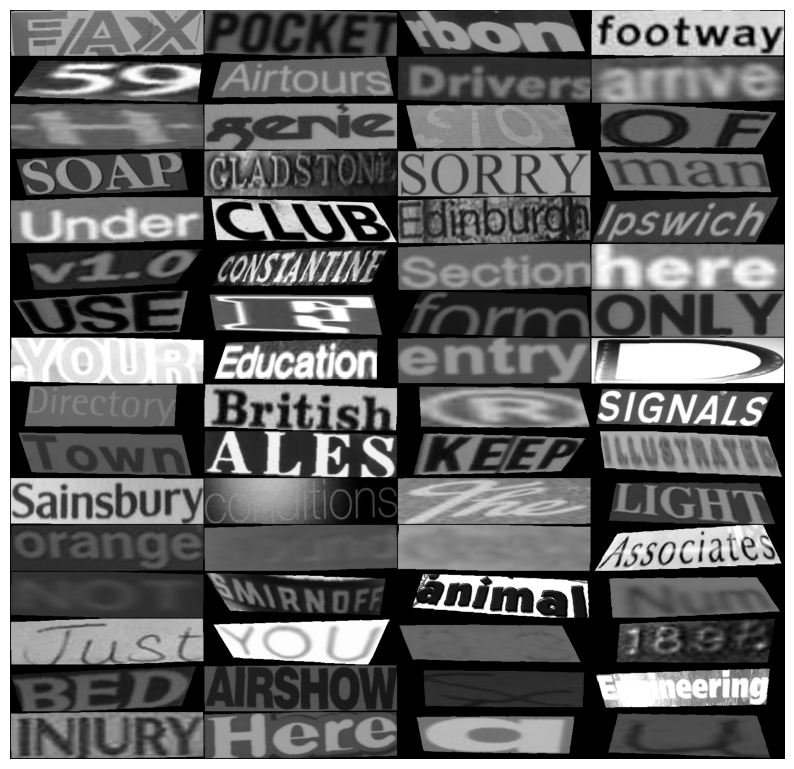

In [23]:
train_features, train_labels, train_lengths = next(iter(train_loader))

def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    print(labels)
    plt.show()


show_batch(train_features, train_labels)

### **Create model**

In [ ]:
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model("resnet34", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  

        return x

In [25]:
hidden_size = 256 
n_layers = 3 
dropout_prob = 0.2 
unfreeze_layers = 3 
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = CRNN(
    vocab_size=vocab_size, 
    hidden_size=hidden_size, 
    n_layers=n_layers, 
    dropout=dropout_prob, 
    unfreeze_layers=unfreeze_layers,
).to(device)

In [26]:
model.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print("Output shape:", output.shape)

Output shape: torch.Size([14, 64, 37])


### **Training**

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels, labels_len) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    max_grad_norm=2,
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start = time.time()

        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long,
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\t Time: {time.time() - start:.2f} seconds"
        )

        scheduler.step()

    return train_losses, val_losses

In [31]:
epochs = 100
lr = 1e-4
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean",
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=0.1
)

In [32]:
train_losses, val_losses = fit(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs 
)

EPOCH 1:	Train loss: 4.9063	Val loss: 3.5601		 Time: 11.10 seconds
EPOCH 2:	Train loss: 3.4706	Val loss: 3.5075		 Time: 7.05 seconds
EPOCH 3:	Train loss: 3.3090	Val loss: 3.2612		 Time: 7.09 seconds
EPOCH 4:	Train loss: 3.1026	Val loss: 3.0639		 Time: 7.21 seconds
EPOCH 5:	Train loss: 2.8645	Val loss: 2.8205		 Time: 7.10 seconds
EPOCH 6:	Train loss: 2.5777	Val loss: 2.5880		 Time: 7.22 seconds
EPOCH 7:	Train loss: 2.2798	Val loss: 2.3320		 Time: 8.73 seconds
EPOCH 8:	Train loss: 2.0388	Val loss: 2.0529		 Time: 9.16 seconds
EPOCH 9:	Train loss: 1.7907	Val loss: 1.9031		 Time: 8.72 seconds
EPOCH 10:	Train loss: 1.5178	Val loss: 1.6987		 Time: 7.32 seconds
EPOCH 11:	Train loss: 1.3034	Val loss: 1.6165		 Time: 6.89 seconds
EPOCH 12:	Train loss: 1.1055	Val loss: 1.4629		 Time: 7.48 seconds
EPOCH 13:	Train loss: 0.9315	Val loss: 1.5238		 Time: 7.63 seconds
EPOCH 14:	Train loss: 0.8397	Val loss: 1.3248		 Time: 7.50 seconds
EPOCH 15:	Train loss: 0.7228	Val loss: 1.3622		 Time: 7.25 seconds
EPO

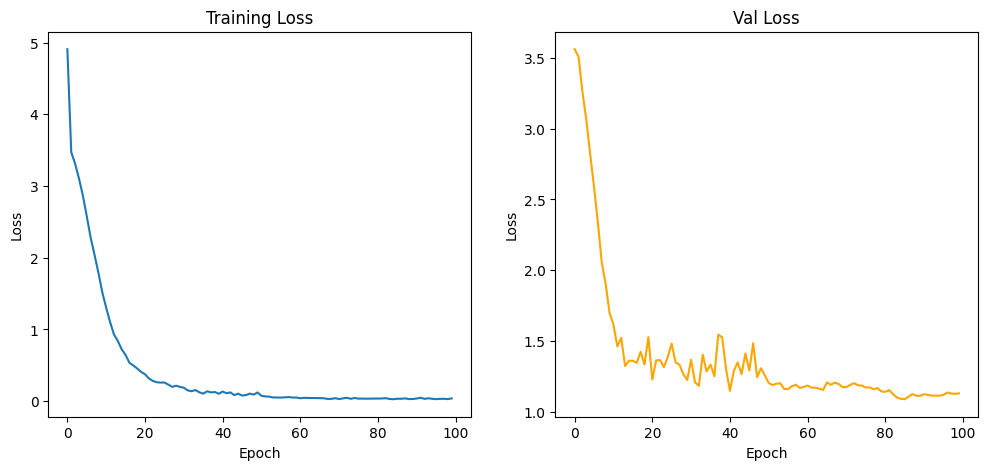

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(val_losses, color="orange")
ax[1].set_title("Val Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
plt.show()

### **Evaluation**

In [34]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val loss: ", val_loss)
print("Test loss: ", test_loss)

Evaluation on val/test dataset
Val loss:  1.1317800283432007
Test loss:  1.5538382530212402


### **Make Predictions with PostProcessing**

In [35]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)

def decode_label(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

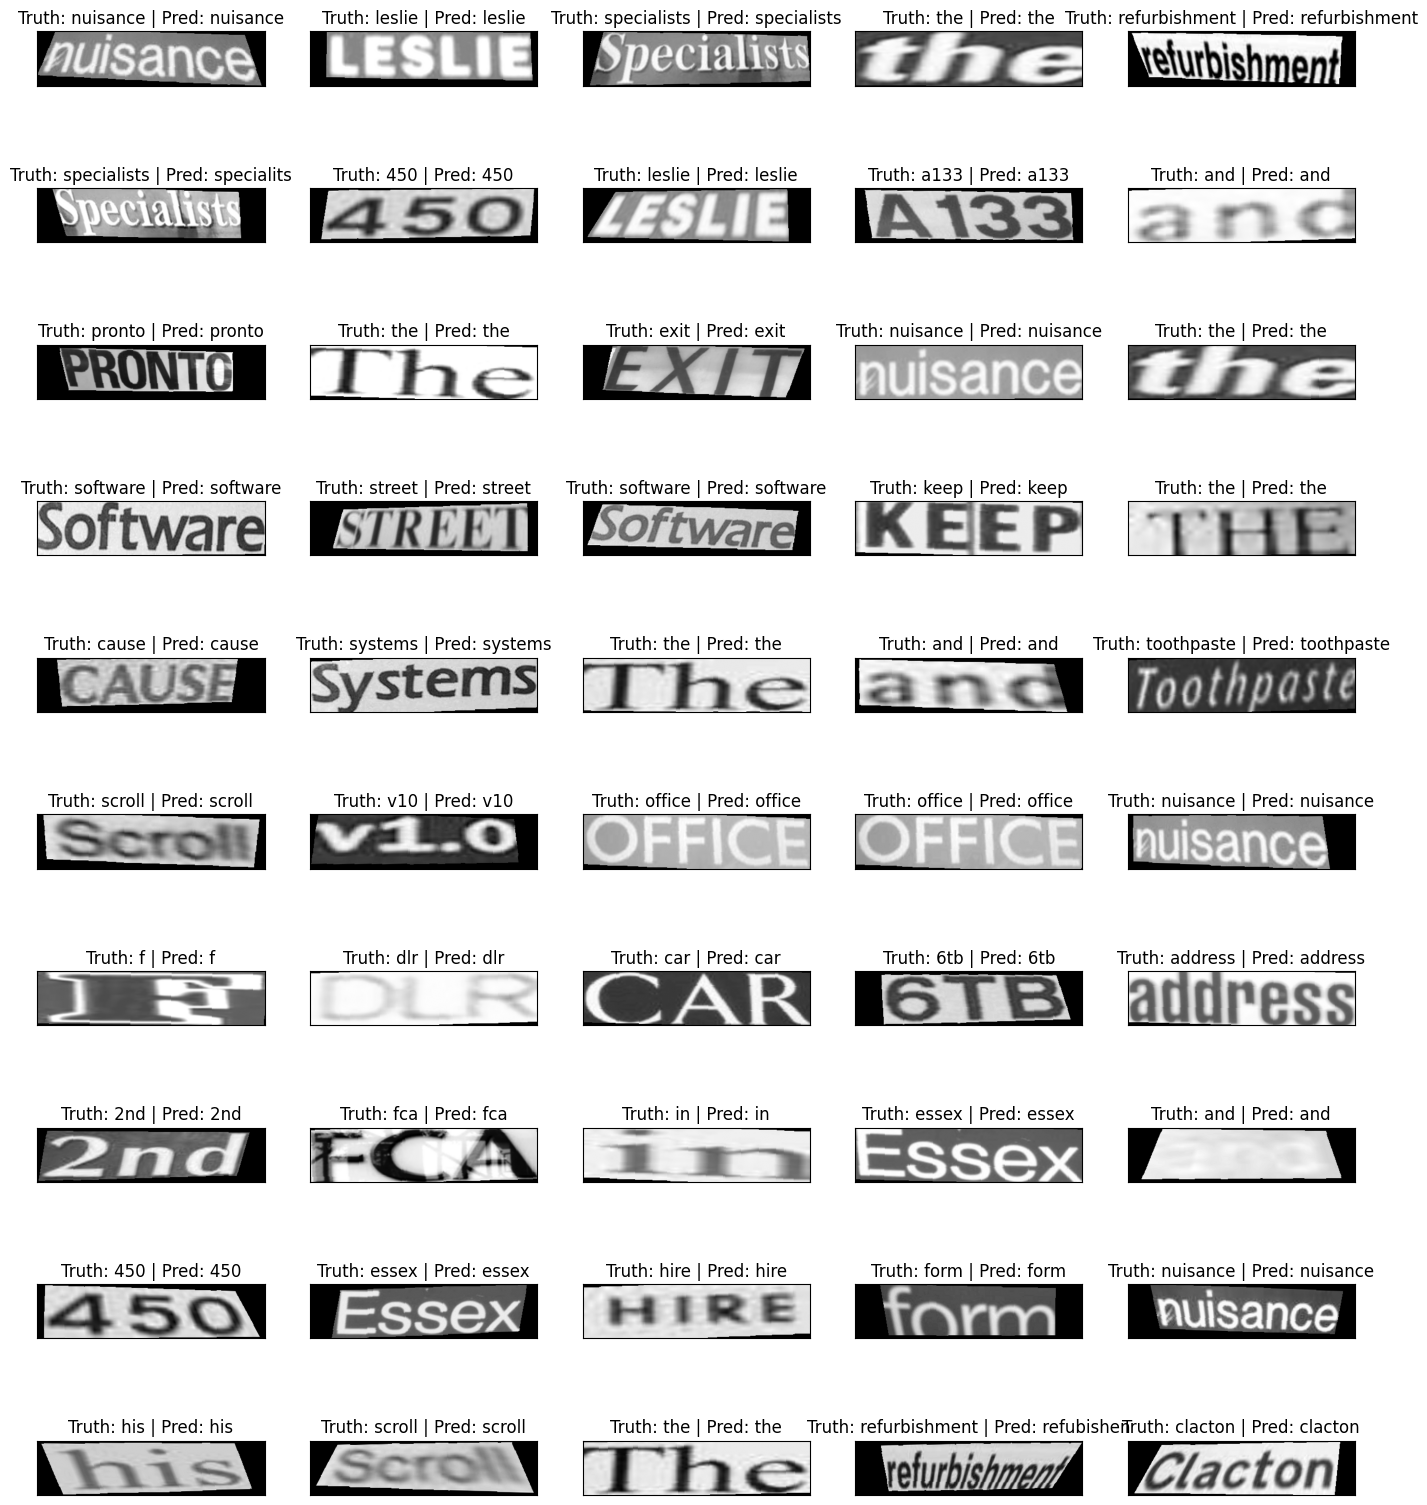

In [36]:
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

### **Test dataset**

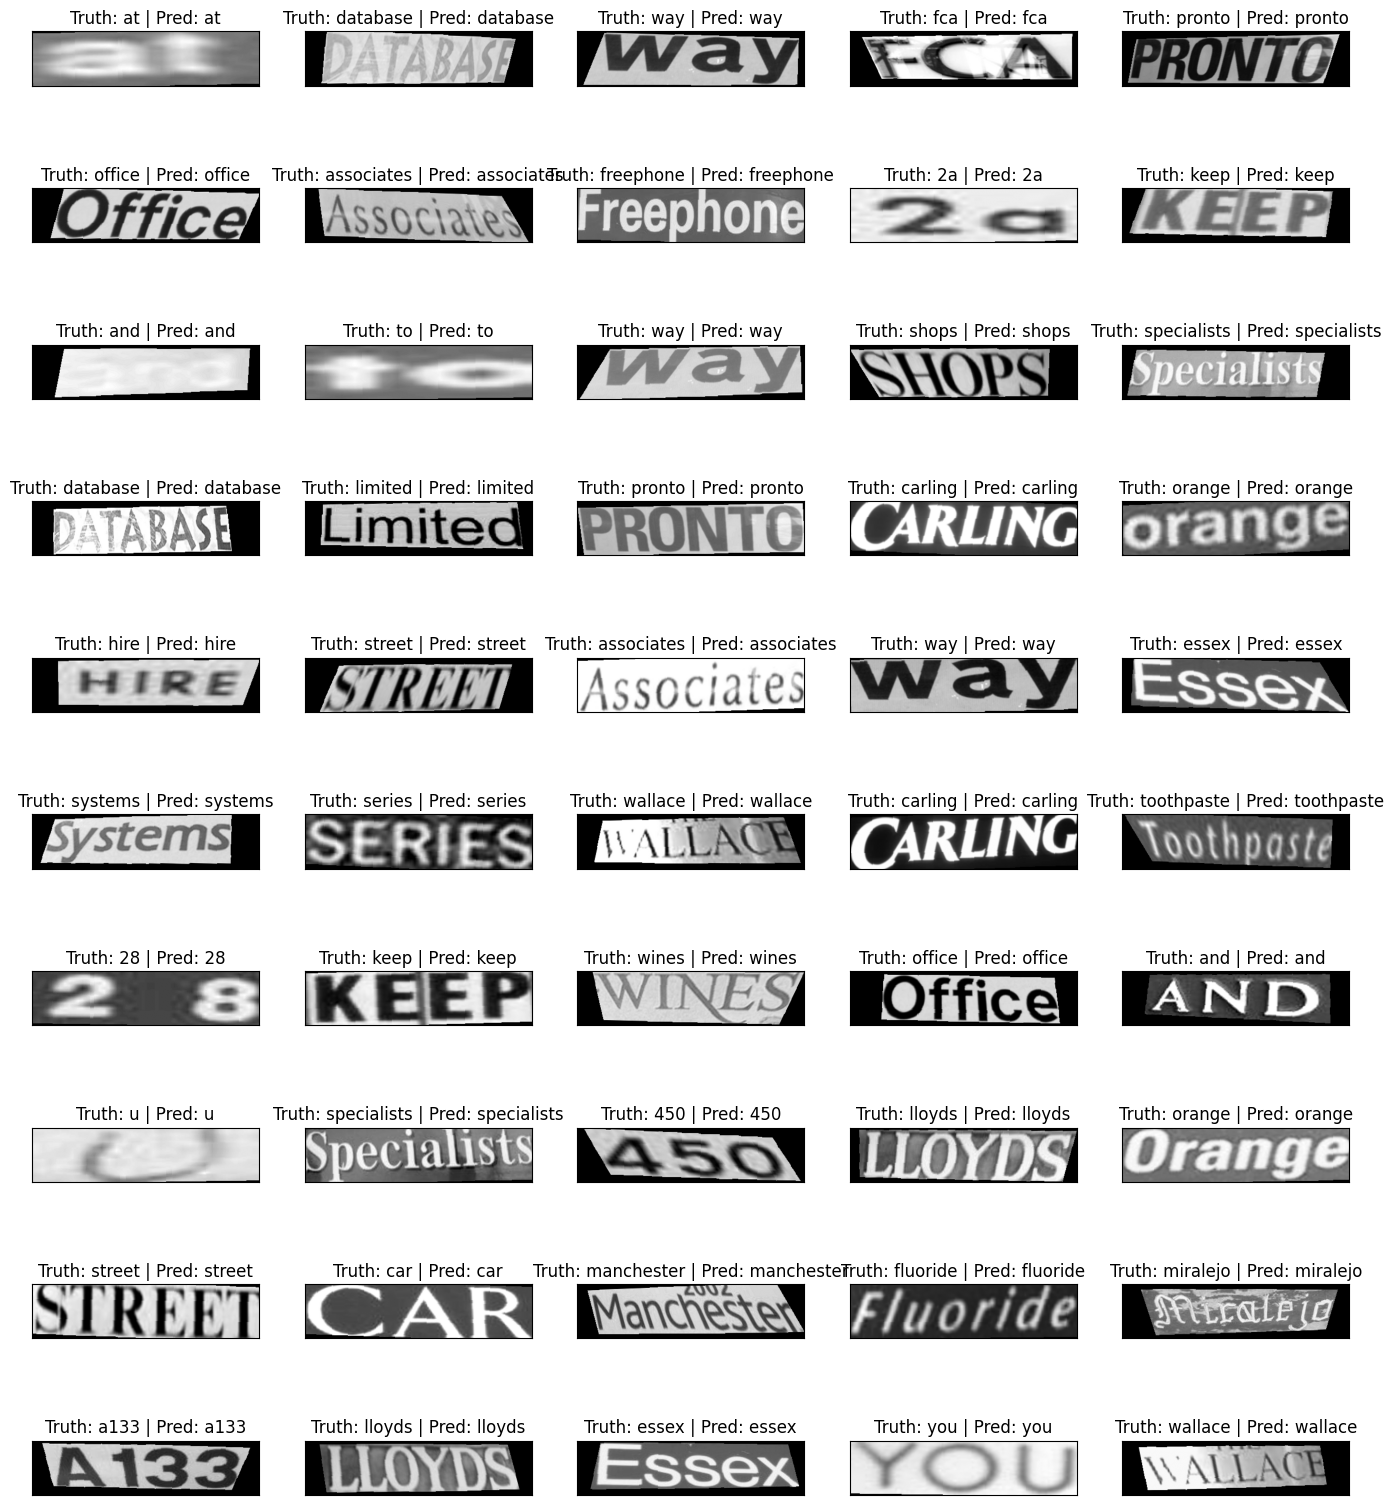

In [37]:
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

### **Save model**

In [38]:
save_model_path = "ocr_crnn.pt"
torch.save(model.state_dict(), save_model_path)